In [1]:
#setting up libs
import numpy as np
import pandas as pd
import warnings

from collections import OrderedDict

import random as random
np.random.seed(1)
import time
import datetime
from pprint import pprint

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.show() 
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.show() 

from scipy.stats import mode 
from scipy.stats import pearsonr 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import datasets
from sklearn import svm

warnings.filterwarnings("ignore")


#█    ▀  █▀▀▄ █▀▀█ █▀▀█ █▀▀█ █  █ █▀▀ 
#█   ▀█▀ █▀▀▄ █▄▄▀ █▄▄█ █▄▄▀ █▄▄█ ▀▀█ 
#▀▀▀ ▀▀▀ ▀▀▀  ▀ ▀▀ ▀  ▀ ▀ ▀▀ ▄▄▄█ ▀▀▀ 
#

import time
import pandas as pd
import datetime

from numpy import log, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import rand 
seed = 1

import pyspark.sql.functions as F

from pyspark.sql.types import *
from pyspark.sql.functions import col

from pyspark.sql import SparkSession
import warnings

#variable for skipping all the plotting code for debugging processing
plotting = True
start_time = time.perf_counter()
start_time_og = time.perf_counter()

#█▀▄ ▄▀█ ▀█▀ ▄▀█    █▀▄ █ █▀█ 
#█▄▀ █▀█  █  █▀█    █▄▀ █ █▀▄ 
#

#main data directory
data_dir = "/mnt/e/2021/Applied Data Science/Project 1/Data/"

#▀█▀ ▄▀█ ▀▄▀ █    █▀▄ ▄▀█ ▀█▀ ▄▀█ 
# █  █▀█ █ █ █    █▄▀ █▀█  █  █▀█ 
#

#file location
file_base = "_tripdata_"

#indexs for each of the main data set types
ywl_i = 0 
grn_i = 1
fhv_i = 2
hvf_i = 3
taxi_types_n = 2

#names related to each cab type in order
taxi_file_names = ["yellow", "green"]
full_names = ["yellow cabs", "green cabs"]

#column names for each cab type in order
column_names = [
    ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge'],
    ['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
    ['dispatching_base_num', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'SR_Flag'],
    ['hvfhs_license_num', 'dispatching_base_num', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'SR_Flag']
]

#2018 fhv files which was giving me trouble so added this schema for it
bad_fhv_schema = [2, 2018, ['Pickup_DateTime','DropOff_datetime', 'PULocationID', 'DOLocationID', 'SR_Flag','dispatching_base_number']]


#aliases for pickup time and dropoff time
pickup_time = ['tpep_pickup_datetime','lpep_pickup_datetime','pickup_datetime','pickup_datetime','Pickup_DateTime']
dropoff_time = ['tpep_dropoff_datetime','lpep_dropoff_datetime','dropoff_datetime','dropoff_datetime','DropOff_datetime']

#irrelavent collumns that can be dropped
irrelavent_columns = ['dispatching_base_number','DOtime','hvfhs_license_num','dispatching_base_num','VendorID','store_and_fwd_flag','extra','MTA_tax','improvement_surcharge','tip_amount','tolls_amount', 'ehail_fee', 'improvement_surcharge', 'congestion_surcharge']


#▀█▀ ▄▀█ ▀▄▀ █    █   █▀█ █▀▀ ▄▀█ ▀█▀ █ █▀█ █▄ █ █▀ 
# █  █▀█ █ █ █    █▄▄ █▄█ █▄▄ █▀█  █  █ █▄█ █ ▀█ ▄█ 
#

#location processing variables
#locations that will be removed as considered invalid
bad_locations = [1,132,138,264,265]

#location of the location id file
location_file = "taxi+_zone_lookup.csv"

#list of boroughs names as in the location file
boroughs = ["Bronx","Brooklyn","Manhattan","Queens","Staten Island","EWR","Unknown"]


#█▀▄ ▄▀█ ▀█▀ █▀▀    █▀▄ █▀▀ █▀▀ █▀ 
#█▄▀ █▀█  █  ██▄    █▄▀ ██▄ █▀  ▄█ 
#
months_in_year = 12

#years of data used
years = [2019, 2020]

#feb 2019 was when fhvhv file started
fhvhv_started = [2,2019] 

#late feb 2020 was when the first case of covid was observed in NYC
covid_started = [2,2020] 

#preprocessing arrays

#hours each day to seperate each count
day_time_breakdown = [0,6,12,18]

#day of the year covid started on
start_day = int(datetime.datetime.strptime(
    " ".join([str(int) for int in covid_started]), 
    "%m %Y").__format__("%j"))

#pretty self explanitory
days_in_2020 = 366


#█▀█ █ █ ▀█▀ █   █ █▀▀ █▀█ █▀ 
#█▄█ █▄█  █  █▄▄ █ ██▄ █▀▄ ▄█ 
#

outlier_percent = (1-.99)/2
fare_amount_graph_buffer = 15
percentile_accuracy = 0.00001


#█▀▀ █▀█ █ █ █ █▀▄    █▀▄ █▀▀ █▀▀ █▀ 
#█▄▄ █▄█ ▀▄▀ █ █▄▀    █▄▀ ██▄ █▄▄ ▄█ 
#

#files
covid_restrictions_file = "covid_restrictions.csv"
covid_cases_file = "COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv"

#list of boroughs as named in the covid file (same order)
covid_boroughs =["bx","bk","mn","qn","si"]

#covid data of interest
covid_of_interest = ['case_count', 'probable_case_count','hospitalized_count', 'death_count', 'probable_death_count',
       'case_count_7day_avg', 'all_case_count_7day_avg', 'hospitalized_count_7day_avg',
       'death_count_7day_avg', 'all_death_count_7day_avg']



processed_data_file = "_processed_data_"
output_file = "combined_taxi_data_tallyed.csv"




case_lag = 49


In [2]:
#█▀▀ ▄▀█ █▀ █▀▀ █▀ 
#█▄▄ █▀█ ▄█ ██▄ ▄█ 
# #importing covid case data
covid_cases = pd.read_csv(data_dir + covid_cases_file)

#makes the names of columns lowercase
covid_cases.columns = covid_cases.columns.str.lower()

#makes the date column datetime object
covid_cases['date_of_interest'] = covid_cases['date_of_interest']\
    .transform(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

#renaming some badly named columns
covid_cases['probable_death_count'] = covid_cases['death_count_probable']
covid_cases['hospitalized_count_7day_avg'] = covid_cases['hosp_count_7day_avg']
covid_cases = covid_cases.drop(['death_count_probable','hosp_count_7day_avg'],axis=1)

In [3]:

#main data directory
data_dir = "/mnt/e/2021/Applied Data Science/Project 1/Data/"
input_file = "combined_taxi_data_good(2).csv"

#list of boroughs names as in the location file
boroughs = ["Bronx","Brooklyn","Manhattan","Queens","Staten Island"]

df = pd.read_csv(data_dir + input_file)
df = df.loc[df["fhv"] == 0]

In [4]:
df.loc[df["borough"] == 2]

,Unnamed: 0,day_year,day_week,week,borough,fhv,2019_night,2019_morn,2019_arvo,2019_even,...,phase_2,phase_3,phase_4,large_capacity_public,gatherings,broadway,movies,stadium_capcity,indoor_religious,curfew
4,4,32,6,4,2,0,46401,61293,113616,113702,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
14,14,33,0,5,2,0,55188,48120,97169,73240,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
24,24,34,1,5,2,0,10238,87105,93468,100421,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
34,34,35,2,5,2,0,11333,96516,101806,119016,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
44,44,36,3,5,2,0,15254,102070,110476,139430,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,3294,361,6,51,2,0,21429,29171,63555,59576,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0
3304,3304,362,0,52,2,0,27110,25191,62766,50039,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0
3314,3314,363,1,52,2,0,10122,45975,75511,55592,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0
3324,3324,364,2,52,2,0,12736,38494,66496,68564,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0


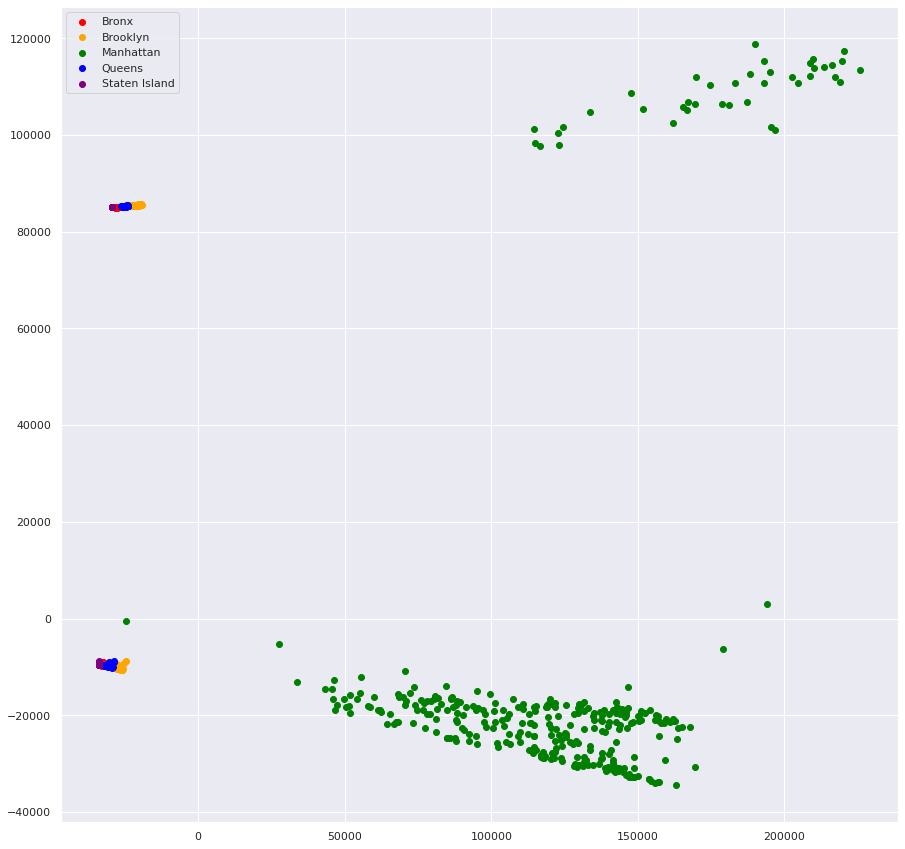

In [5]:
#showing low accuracies from the clustering point of view

#sets up and fits the PCA algorithm with 2 dimensions 
pca = PCA(n_components = 2)
s = pca.fit_transform(df)

#creating colour scheme with each colour below representing its respective class label
colours = ["red", "orange", "green", "blue", "purple"]
labels = boroughs

#plotting each class
for clas, colour, label in zip(np.unique(df["borough"]),colours,labels):
    plt.scatter(s[df["borough"]==clas, 0], s[df["borough"]==clas, 1], label=label, c=colour)
    
#printing the plot
plt.legend()
plt.show()


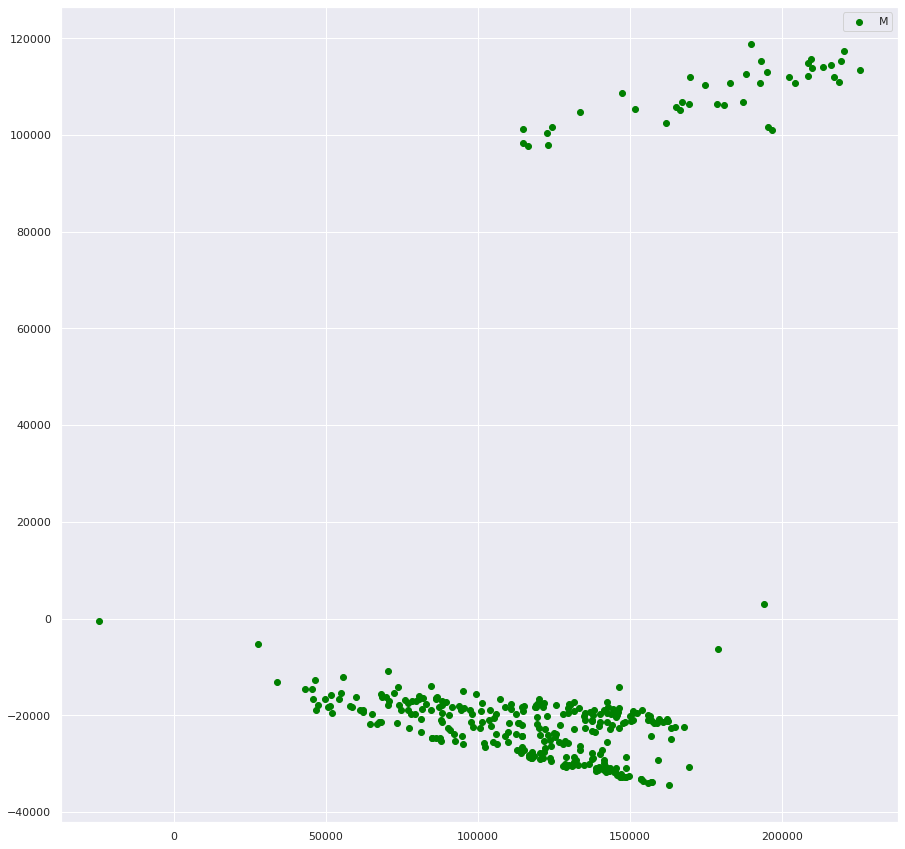

In [6]:
#showing low accuracies from the clustering point of view

df2 = df.loc[df["borough"] == 2]

#sets up and fits the PCA algorithm with 2 dimensions 
#pca = PCA(n_components = 2)
#s = pca.fit_transform(df2)

#creating colour scheme with each colour below representing its respective class label
colours = ["green"]
labels = boroughs[2]

#plotting each class
for clas, colour, label in zip(np.unique(df2["borough"]),colours,labels):
    plt.scatter(s[df["borough"]==clas, 0], s[df["borough"]==clas, 1], label=label, c=colour)
    
#printing the plot
plt.legend()
plt.show()


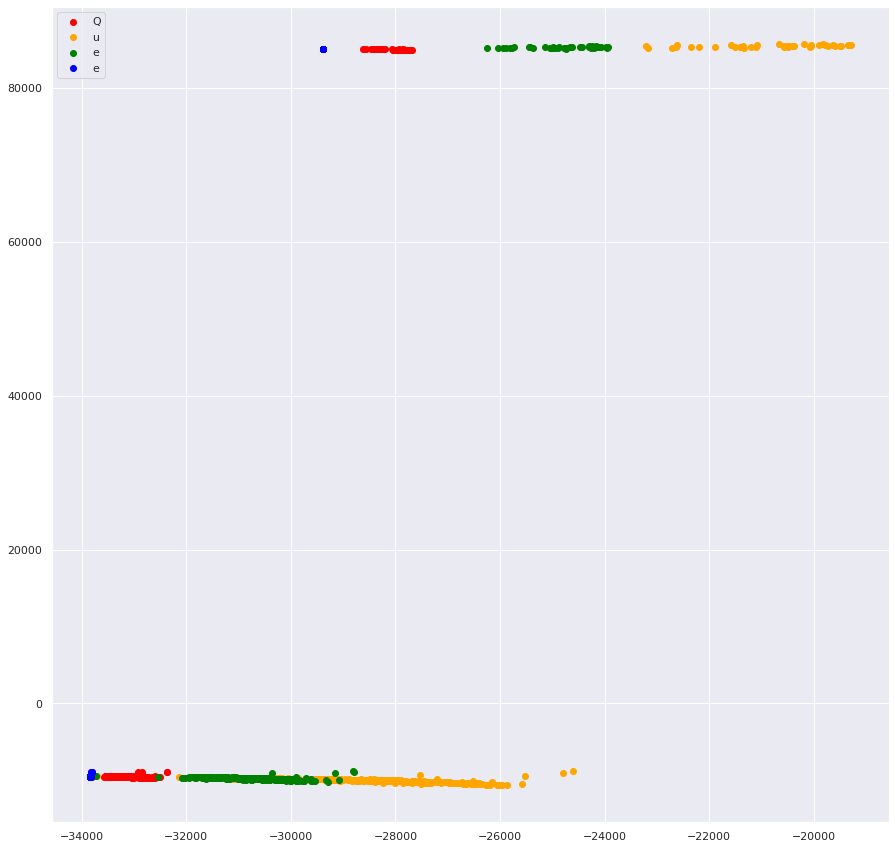

In [7]:
#showing low accuracies from the clustering point of view

df2 = df.loc[df["borough"] != 2]

#sets up and fits the PCA algorithm with 2 dimensions 
#pca = PCA(n_components = 2)
#s = pca.fit_transform(df2)

#creating colour scheme with each colour below representing its respective class label
colours = ["red", "orange", "green", "blue", "purple"]
labels = boroughs[-2]

#plotting each class
for clas, colour, label in zip(np.unique(df2["borough"]),colours,labels):
    plt.scatter(s[df["borough"]==clas, 0], s[df["borough"]==clas, 1], label=label, c=colour)
    
#printing the plot
plt.legend()
plt.show()

In [8]:
df.columns

Index(['Unnamed: 0', 'day_year', 'day_week', 'week', 'borough', 'fhv',
       '2019_night', '2019_morn', '2019_arvo', '2019_even', '2020_night',
       '2020_morn', '2020_arvo', '2020_even', 'total_case_count',
       'total_probable_case_count', 'total_hospitalized_count',
       'total_death_count', 'total_probable_death_count',
       'total_case_count_7day_avg', 'total_all_case_count_7day_avg',
       'total_hospitalized_count_7day_avg', 'total_death_count_7day_avg',
       'total_all_death_count_7day_avg', 'borough_case_count',
       'borough_probable_case_count', 'borough_hospitalized_count',
       'borough_death_count', 'borough_probable_death_count',
       'borough_case_count_7day_avg', 'borough_all_case_count_7day_avg',
       'borough_hospitalized_count_7day_avg', 'borough_death_count_7day_avg',
       'borough_all_death_count_7day_avg', 'pre_k_schools',
       'elementary_schools', 'middle_schools', 'high_schools', 'construction',
       'offices', 'phase_1', 'restaurants

In [9]:
df.corr()

,Unnamed: 0,day_year,day_week,week,borough,fhv,2019_night,2019_morn,2019_arvo,2019_even,...,phase_2,phase_3,phase_4,large_capacity_public,gatherings,broadway,movies,stadium_capcity,indoor_religious,curfew
Unnamed: 0,1.000000,9.999957e-01,-2.613274e-03,9.997802e-01,2.933521e-03,NaN,-0.024914,-0.039357,-0.031288,-0.035643,...,2.300853e-01,2.300853e-01,2.300853e-01,2.300853e-01,-5.799004e-01,-5.623645e-01,-5.623645e-01,-5.626411e-01,-8.739055e-02,6.076002e-01
day_year,0.999996,1.000000e+00,-2.613285e-03,9.997845e-01,1.675010e-16,NaN,-0.024880,-0.039334,-0.031263,-0.035613,...,2.300862e-01,2.300862e-01,2.300862e-01,2.300862e-01,-5.799029e-01,-5.623669e-01,-5.623669e-01,-5.626435e-01,-8.739093e-02,6.076028e-01
day_week,-0.002613,-2.613285e-03,1.000000e+00,-2.337326e-02,1.088365e-17,NaN,0.032732,0.022638,0.017377,0.060197,...,3.741013e-03,3.741013e-03,3.741013e-03,3.741013e-03,1.390068e-02,-1.216202e-02,-1.216202e-02,-1.209292e-02,-2.981925e-03,-2.424883e-03
week,0.999780,9.997845e-01,-2.337326e-02,1.000000e+00,1.635564e-16,NaN,-0.025553,-0.039794,-0.031615,-0.036853,...,2.299465e-01,2.299465e-01,2.299465e-01,2.299465e-01,-5.800350e-01,-5.619627e-01,-5.619627e-01,-5.622407e-01,-8.730545e-02,6.074892e-01
borough,0.002934,1.675010e-16,1.088365e-17,1.635564e-16,1.000000e+00,NaN,-0.011626,-0.007945,-0.008508,-0.010471,...,-1.508130e-16,-1.508130e-16,-1.508130e-16,-1.508130e-16,-2.128869e-16,-2.140274e-16,-2.140274e-16,-2.123213e-16,-2.007900e-16,-6.191039e-17
fhv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_night,-0.024914,-2.488002e-02,3.273194e-02,-2.555284e-02,-1.162598e-02,NaN,1.000000,0.624776,0.779712,0.699756,...,1.179755e-02,1.179755e-02,1.179755e-02,1.179755e-02,2.489226e-02,2.022400e-02,2.022400e-02,2.027384e-02,2.289461e-02,-8.214334e-03
2019_morn,-0.039357,-3.933416e-02,2.263832e-02,-3.979353e-02,-7.944536e-03,NaN,0.624776,1.000000,0.969833,0.986747,...,1.381385e-02,1.381385e-02,1.381385e-02,1.381385e-02,3.378532e-02,3.022831e-02,3.022831e-02,3.023508e-02,2.128743e-02,-2.133491e-02
2019_arvo,-0.031288,-3.126281e-02,1.737698e-02,-3.161513e-02,-8.508466e-03,NaN,0.779712,0.969833,1.000000,0.983794,...,2.052847e-02,2.052847e-02,2.052847e-02,2.052847e-02,3.249824e-02,3.035032e-02,3.035032e-02,3.036508e-02,2.802296e-02,-6.424563e-03
2019_even,-0.035643,-3.561262e-02,6.019661e-02,-3.685273e-02,-1.047132e-02,NaN,0.699756,0.986747,0.983794,1.000000,...,1.664157e-02,1.664157e-02,1.664157e-02,1.664157e-02,3.284633e-02,2.619208e-02,2.619208e-02,2.621174e-02,2.251914e-02,-1.753610e-02


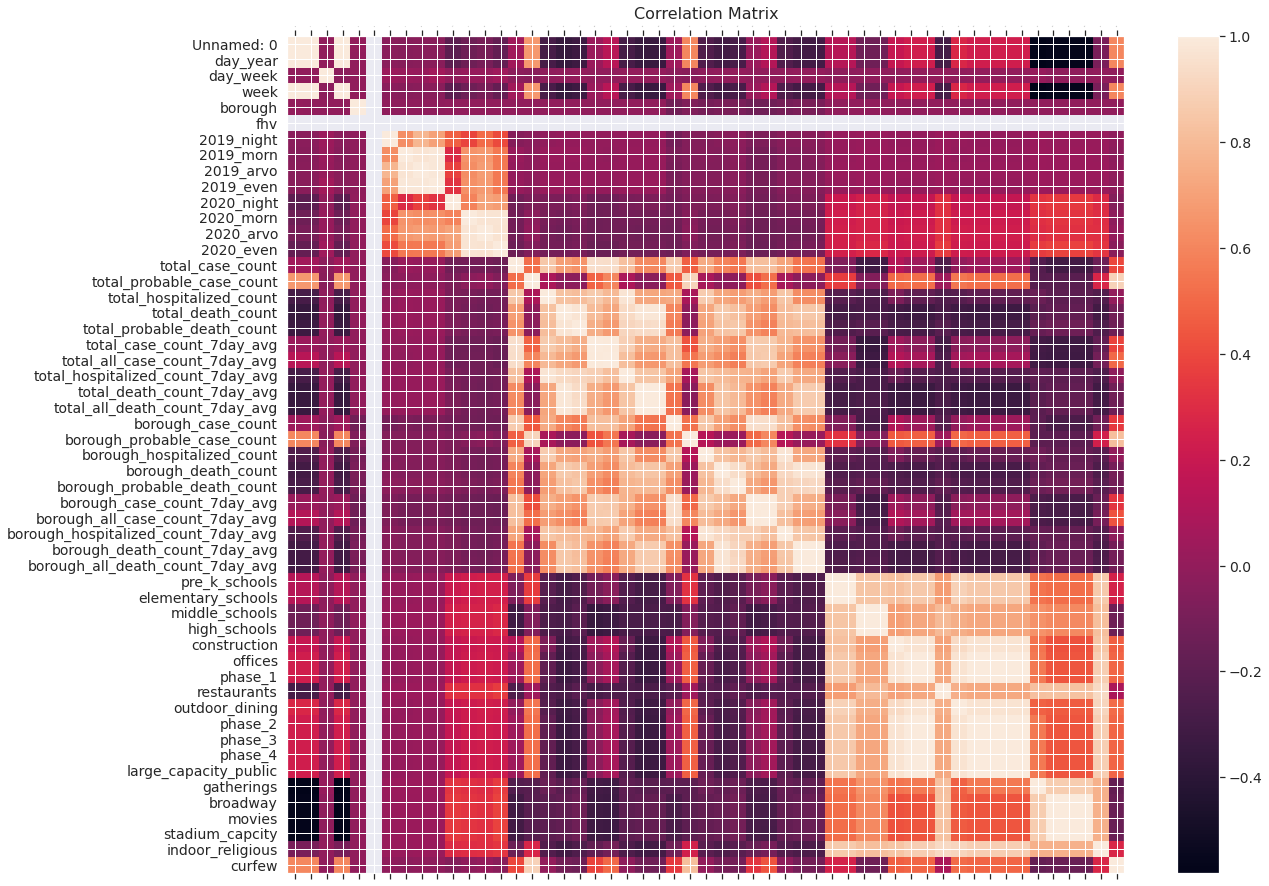

In [10]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), fontsize=0, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

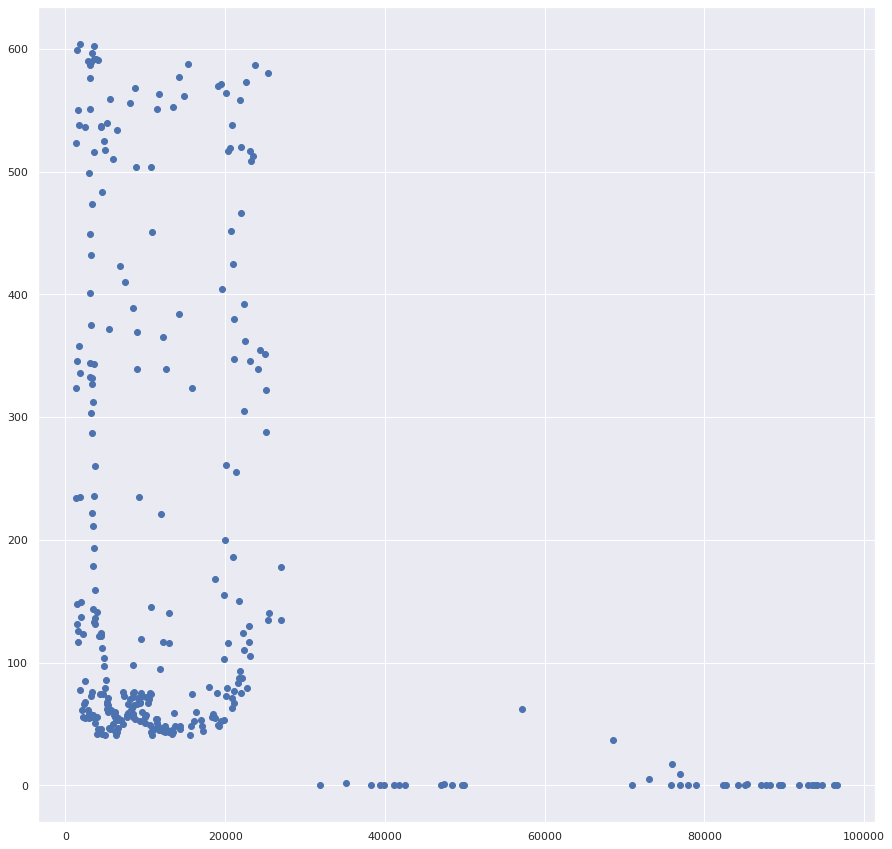

In [11]:
# Fixing random state for reproducibility
np.random.seed(19680801)

dft = df.loc[df["borough"] == 2]

#N = 50
x = dft["2020_morn"]
y = dft["borough_all_case_count_7day_avg"]
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y)#, c=colors, alpha=0.5)
plt.show()

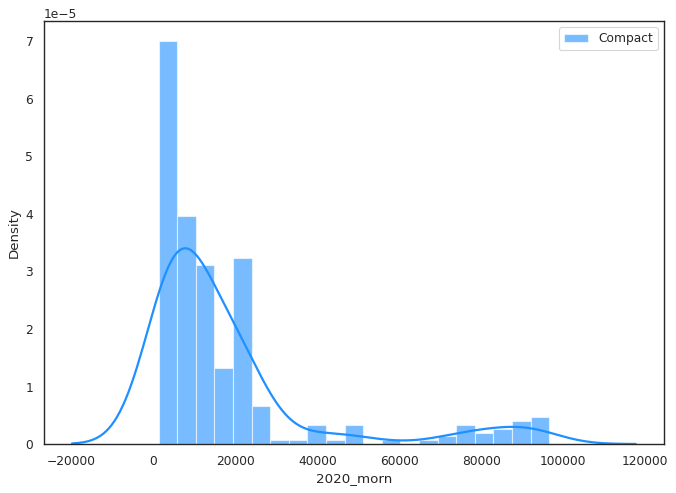

In [12]:
import seaborn as sns
sns.set_style("white")

# Import data
x1 = dft["2020_morn"]

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Compact", **kwargs)
#plt.xlim(50,75)
plt.legend();

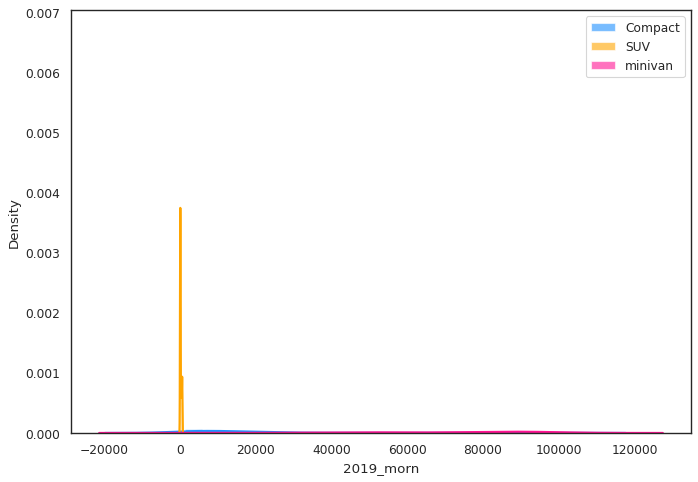

In [13]:
import seaborn as sns
sns.set_style("white")

# Import data
x1 = dft["2020_morn"]
x2 = dft["borough_all_case_count_7day_avg"]
x3 = dft["2019_morn"]

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Compact", **kwargs)
sns.distplot(x2, color="orange", label="SUV", **kwargs)
sns.distplot(x3, color="deeppink", label="minivan", **kwargs)
#plt.xlim(50,75)
plt.legend();

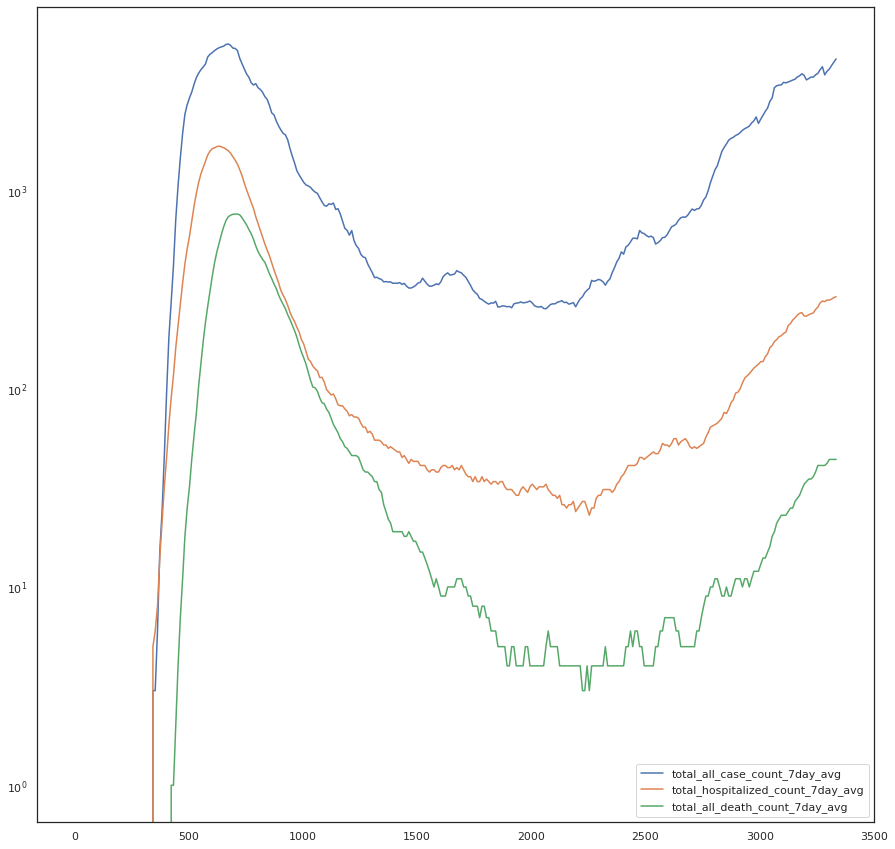

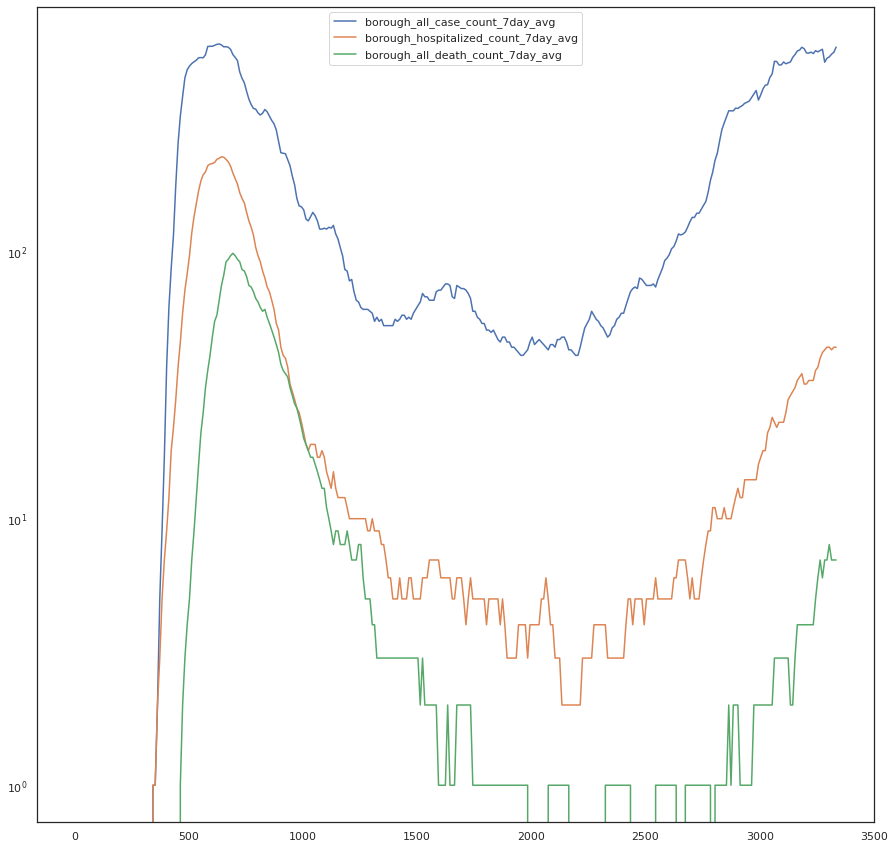

In [14]:
fig, ax = plt.subplots()
#xticks = (dft["week"]*(366/52) + dft["day"])
#lns1 = ax.plot(xticks, dft[["2020_morn"]], color = 'green', label = "2020_morn")


dft[[
     'total_all_case_count_7day_avg', 
     'total_hospitalized_count_7day_avg',
     'total_all_death_count_7day_avg',
]].plot(ax = ax)


ax.set_yscale('log')

fig2, ax2 = plt.subplots()
dft[[
     'borough_all_case_count_7day_avg', 
     'borough_hospitalized_count_7day_avg',
     'borough_all_death_count_7day_avg'
        ]].plot(ax = ax2)
ax2.set_yscale('log')





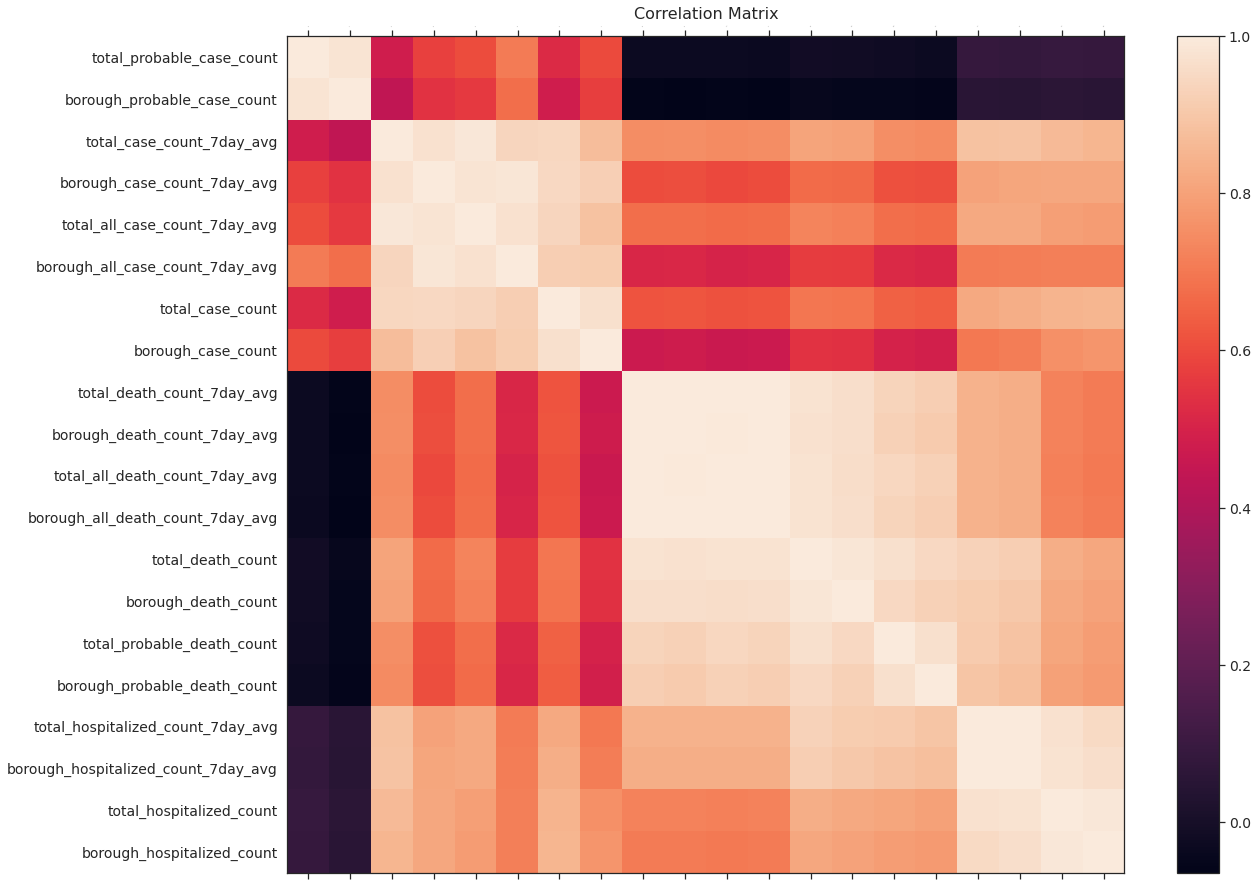

In [15]:
covid_cols = [
     'total_probable_case_count',
     'borough_probable_case_count',
    
     'total_case_count_7day_avg',
     'borough_case_count_7day_avg',
     'total_all_case_count_7day_avg', 
     'borough_all_case_count_7day_avg', 
     'total_case_count', 
     'borough_case_count', 

     'total_death_count_7day_avg', 
     'borough_death_count_7day_avg', 
     'total_all_death_count_7day_avg',
     'borough_all_death_count_7day_avg',
     'total_death_count', 
     'borough_death_count', 
     'total_probable_death_count',
     'borough_probable_death_count',
    
    
     'total_hospitalized_count_7day_avg',
     'borough_hospitalized_count_7day_avg',
     'total_hospitalized_count', 
     'borough_hospitalized_count', 
]

dfs = dft[covid_cols]




f = plt.figure(figsize=(19, 15))
plt.matshow(dfs.corr(), fignum=f.number)
plt.xticks(range(dfs.select_dtypes(['number']).shape[1]), fontsize=0, rotation=45)
plt.yticks(range(dfs.select_dtypes(['number']).shape[1]), dfs.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [16]:
#correlation between taxi numbers in different boroughs
dfs.index

Int64Index([   4,   14,   24,   34,   44,   54,   64,   74,   84,   94,
            ...
            3244, 3254, 3264, 3274, 3284, 3294, 3304, 3314, 3324, 3334],
           dtype='int64', length=334)

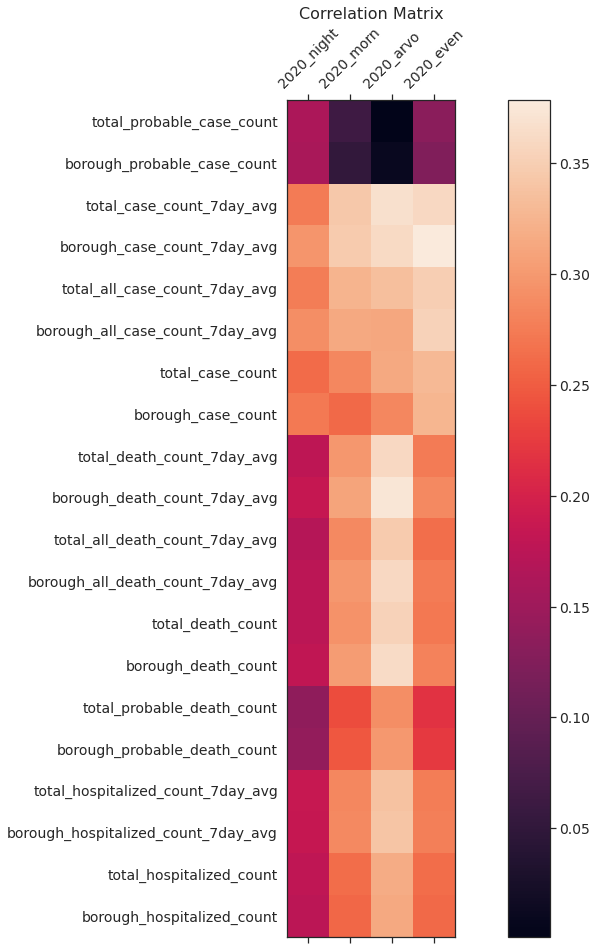

In [17]:
day_parts_2020 = ["2020_night","2020_morn","2020_arvo","2020_even"]
column_temp1 = covid_cols.copy()
column_temp1.extend(day_parts_2020)

dfs = dft[column_temp1].corr().drop(day_parts_2020)[day_parts_2020].abs()#[covid_cols, day_parts_2020]


f = plt.figure(figsize=(19, 15))
plt.matshow(dfs, fignum=f.number)
plt.xticks(range(dfs.select_dtypes(['number']).shape[1]), dfs.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(dfs.select_dtypes(['number']).shape[0]), dfs.select_dtypes(['number']).index, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [28]:
max_corr_delta = 0
max_corr = 0
max_corr_index = dfs.unstack().sort_values(ascending=False).index[0]
max_corr = dfs.unstack().sort_values(ascending=False)[0]

min_day_delta = -30
max_day_delta = 100
taxi_counts = dft[max_corr_index[0]]
covid_day0 = covid_cases["date_of_interest"][0]
day0 = dft["day_year"].values[0]

max_corr_index_use = [0,0]
if(max_corr_index[1].startswith('borough')):
    max_corr_index_use[0] = max_corr_index[0]
    max_corr_index_use[1] = "mn"+max_corr_index[1].split('borough')[1]
else:
    max_corr_index_use[0] = max_corr_index[0]
    max_corr_index_use[1] = max_corr_index[1].split('total_')[1]

    
    

for day_delta in range(min_day_delta, max_day_delta):
    
    values = []
    
    datetime0 = datetime.datetime.strptime( " ".join( [str(int) for int in [day0, covid_started[1]]]) ,"%j %Y" ) + datetime.timedelta(day_delta)
    #dft["day"].values
    
    for day_increment in range(0,len(dft)):
        day = datetime0 + datetime.timedelta(day_increment)

            
        val = covid_cases.loc[covid_cases['date_of_interest'] == day][max_corr_index_use[1]].values
        
        if(val.any()):
            values.append(val[0])
        else:
            values.append(0)
    r, p = pearsonr(values, taxi_counts)
    
    if(abs(r) > max_corr):
        print("new high with " + str(max_corr))
        max_corr_delta = day_delta
        max_corr = abs(r)
    print(day_delta)

print(max_corr)
print(max_corr_delta)

-30
-29
-28
new high with 0.3784612836520923
-27
new high with 0.3785154216733279
-26
new high with 0.37975286675204895
-25
new high with 0.3809348353546559
-24
new high with 0.38213278999589173
-23
new high with 0.3833743699647123
-22
new high with 0.3846416912397679
-21
new high with 0.3856643487907132
-20
new high with 0.38649802981220804
-19
new high with 0.3875831906930591
-18
new high with 0.388601595978184
-17
new high with 0.38949813625742086
-16
new high with 0.3902756613016699
-15
new high with 0.39086456100718653
-14
new high with 0.3915380762159383
-13
new high with 0.39247473018716217
-12
new high with 0.3929152398827019
-11
new high with 0.39309661607467666
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
new high with 0.39322036560097595
36
new high with 0.4056139391707842
37
new high with 0.42062285645746167
38
new high with 0.4349151621731696
39
new high with 0.4491543068525624
40
new high 

In [42]:
print(max_corr_delta)
print(max_corr_index_use)


46
['2020_even', 'mn_case_count_7day_avg']


In [30]:
datetime0 = day0

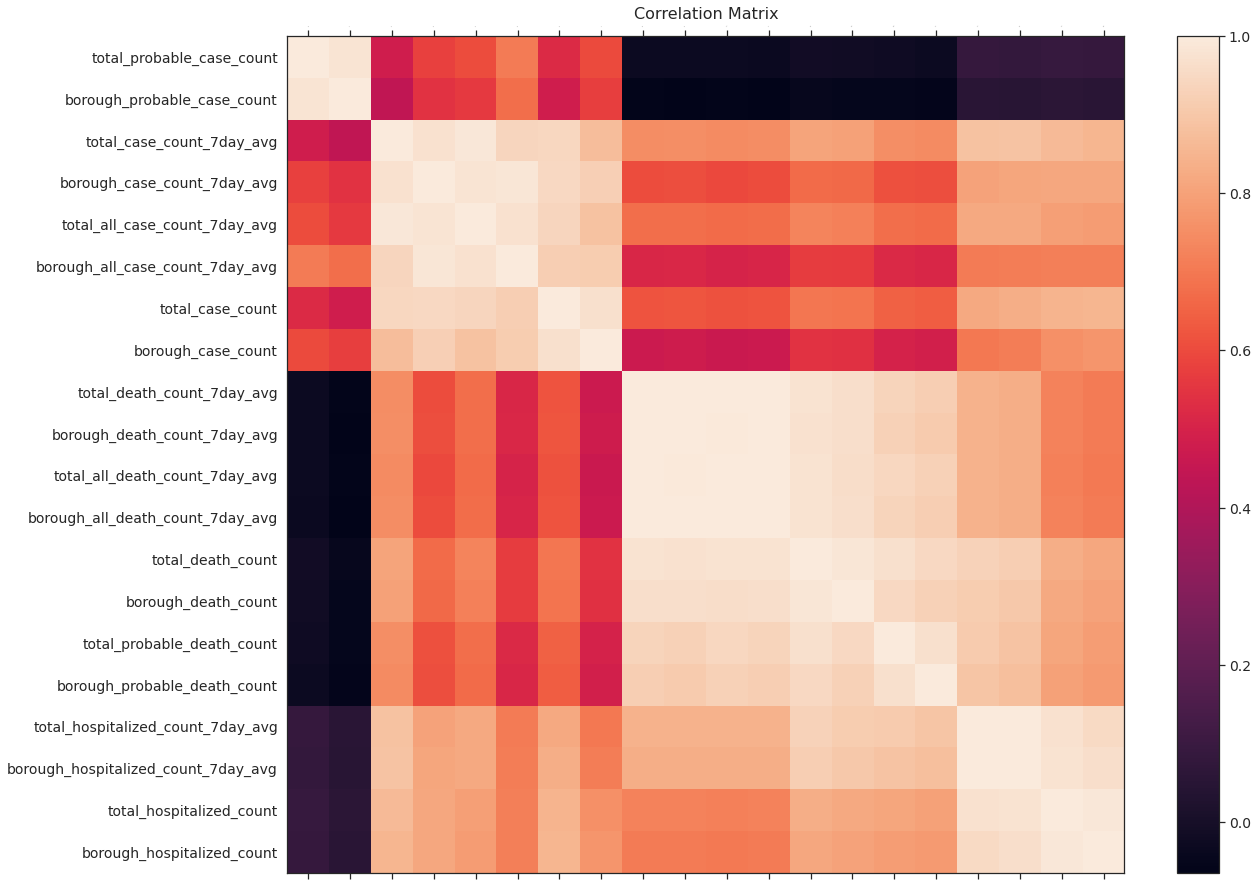

In [32]:
dft

,Unnamed: 0,day_year,day_week,week,borough,fhv,2019_night,2019_morn,2019_arvo,2019_even,...,phase_2,phase_3,phase_4,large_capacity_public,gatherings,broadway,movies,stadium_capcity,indoor_religious,curfew
4,4,32,6,4,2,0,46401,61293,113616,113702,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
14,14,33,0,5,2,0,55188,48120,97169,73240,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
24,24,34,1,5,2,0,10238,87105,93468,100421,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
34,34,35,2,5,2,0,11333,96516,101806,119016,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
44,44,36,3,5,2,0,15254,102070,110476,139430,...,1.0,1.0,1.0,1.0,500.0,1.0,1.0,100000.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,3294,361,6,51,2,0,21429,29171,63555,59576,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0
3304,3304,362,0,52,2,0,27110,25191,62766,50039,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0
3314,3314,363,1,52,2,0,10122,45975,75511,55592,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0
3324,3324,364,2,52,2,0,12736,38494,66496,68564,...,1.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.5,1.0


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

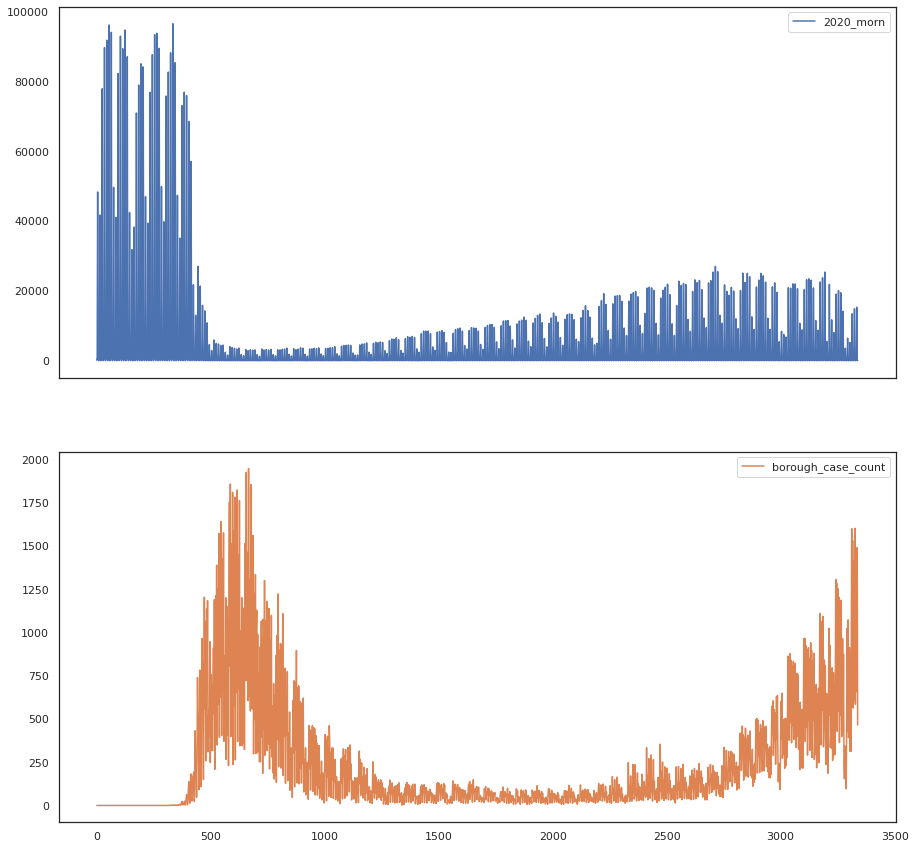

In [33]:
df[["2020_morn","borough_case_count"]].plot(subplots=True)

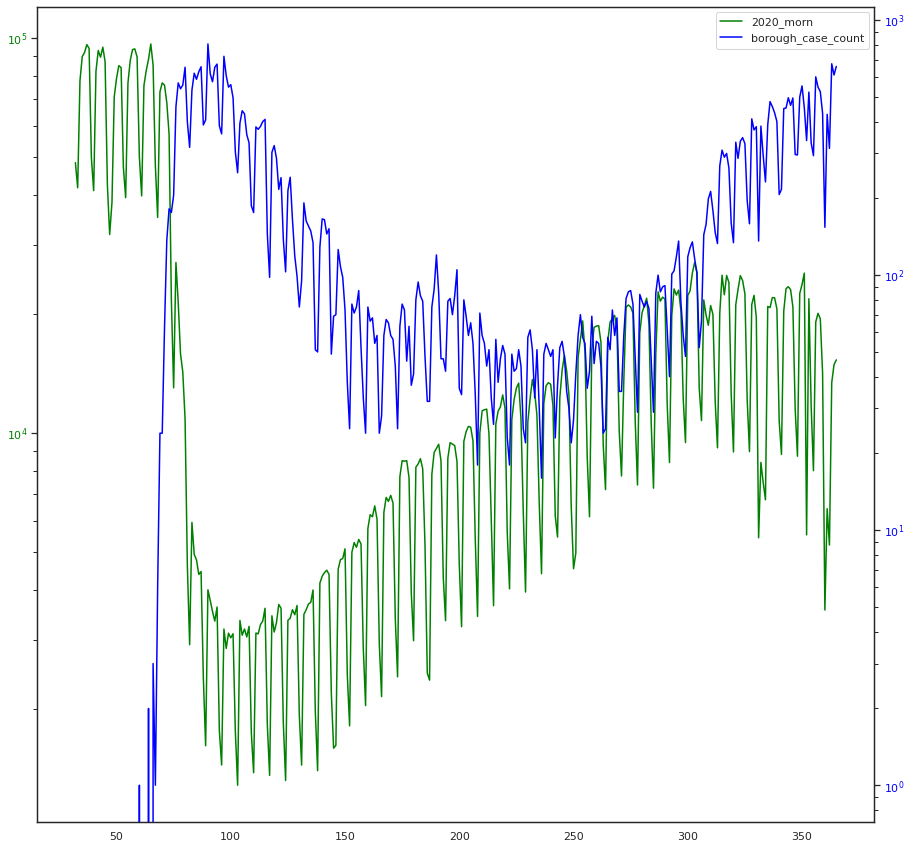

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

fig, ax = plt.subplots()
xticks = (dft["day_year"])

ax.set_xticklabels = xticks
ax.set_xticks = xticks
#ax.set_xticks()

lns1 = ax.plot(xticks, dft[["2020_morn"]], color = 'green', label = "2020_morn")
ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='green')

ax2 = ax.twinx()
lns2 = ax2.plot(xticks, dft[["borough_case_count"]], color = 'blue', label = 'borough_case_count')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='blue')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
#ax.legend(loc = "upper right")
#ax2.legend(loc = "upper right")

#dft[["2020_morn"]].plot(ax=ax, style='b-')
# same ax as above since it's automatically added on the right
#dft[["borough_case_count"]].plot(ax=ax, style='r-',  secondary_y=True)

# add legend --> take advantage of pandas providing us access
# to the line associated with the right part of the axis

TypeError: 'numpy.ndarray' object is not callable

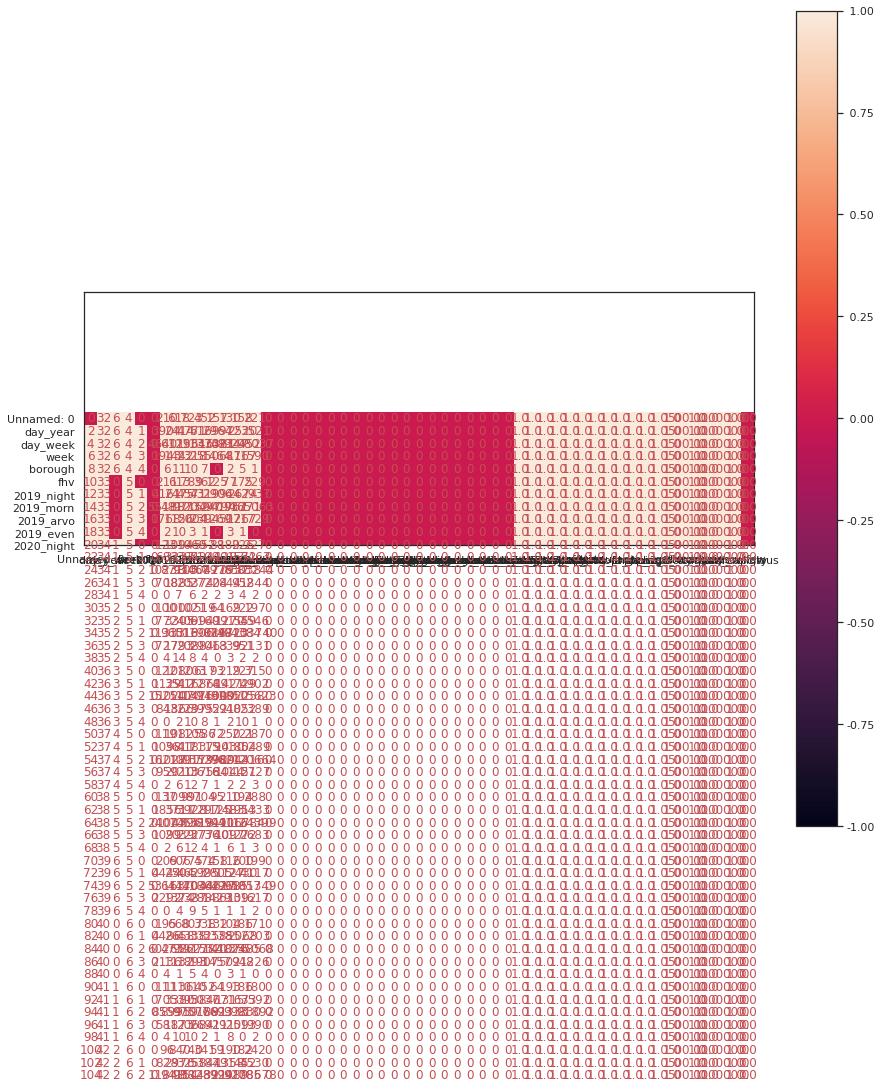

NameError: name 'trn_cls' is not defined

<Figure size 1080x1080 with 0 Axes>

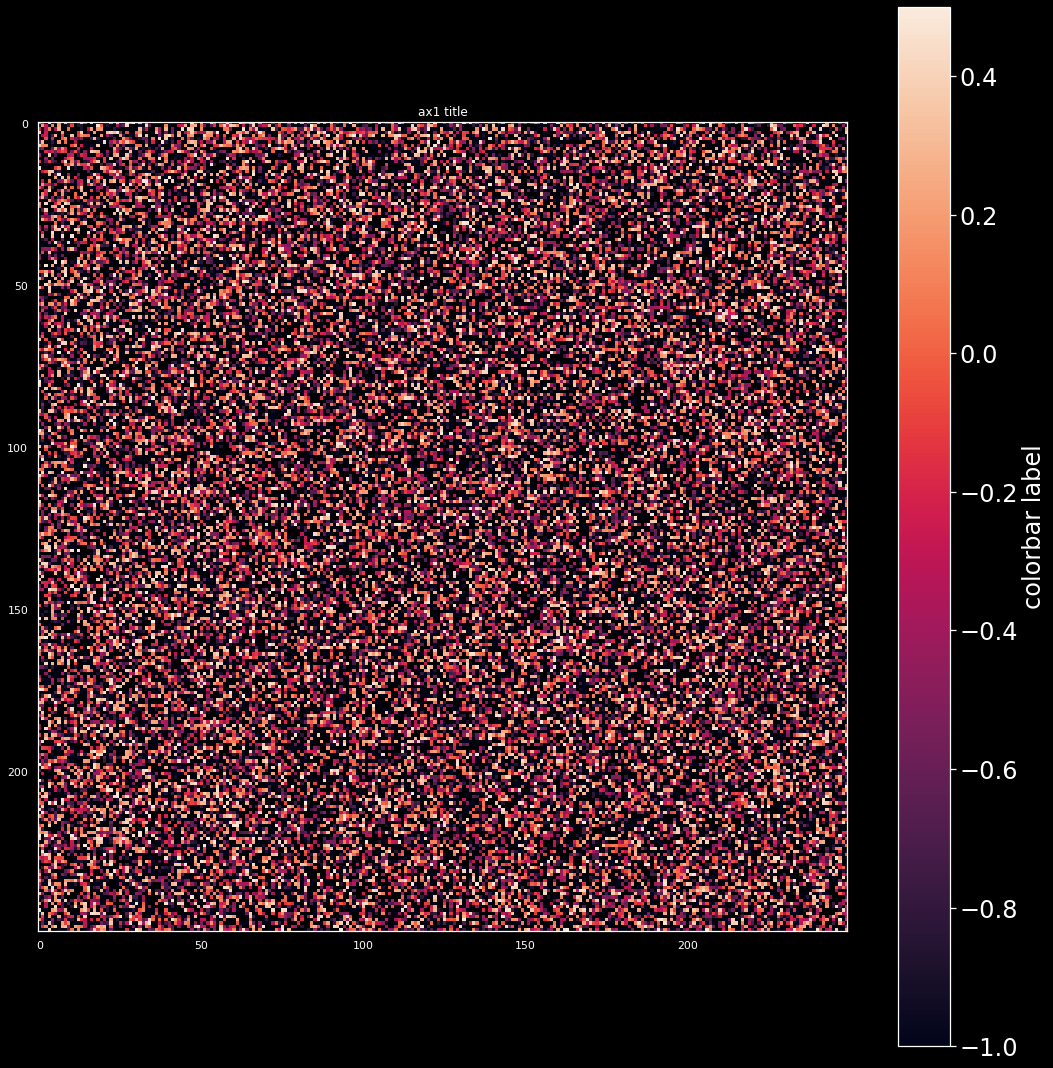

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
data = np.clip(randn(250,250),-1,1)
data = np.ma.masked_where(data > 0.5, data)


fig, ax1 = plt.subplots(1,1)

im = ax1.imshow(data, interpolation='nearest')
cb = plt.colorbar(im)

fg_color = 'white'
bg_color = 'black'

# IMSHOW    
# set title plus title color
ax1.set_title('ax1 title', color=fg_color)

# set figure facecolor
ax1.patch.set_facecolor(bg_color)

# set tick and ticklabel color
im.axes.tick_params(color=fg_color, labelcolor=fg_color)

# set imshow outline
for spine in im.axes.spines.values():
    spine.set_edgecolor(fg_color)    

# COLORBAR
# set colorbar label plus label color
cb.set_label('colorbar label', color=fg_color, fontsize=24)
cb.ax.tick_params(labelsize=24)
# set colorbar tick color
cb.ax.yaxis.set_tick_params(color=fg_color)

# set colorbar edgecolor 
cb.outline.set_edgecolor(fg_color)

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)

fig.patch.set_facecolor(bg_color)    
plt.tight_layout()
plt.show()
#plt.savefig('save/to/pic.png', dpi=200, facecolor=bg_color)